# Before we start:

## Setup

This is best run in colab space and some of the code blocks may take longer than others

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

**Important note**: You might need to install ipyml. To do so, use either <code>pip install ipympl</code> or <code>conda install -c conda-forge ipympl</code>, depending on your Python distribution. You might also have to replace <code>%matplotlib notebook</code> by <code>%matplotlib ipyml</code> in the previous cell (and re-run it)

## Hints

$ \bullet $ Don't forget the periodic boundary conditions when writing your schemes. \
$ \bullet $ The method <code>np.roll</code> will help you a lot. But if you want a small challenge, you can decide not to use it. \
$ \bullet $ In Python, <code> f[:] = </code> updates the content of the array whereas <code> f = </code> creates a new array. \
$ \bullet $ You can pause an animation called "anim" using <code>anim.pause()</code>, and resume it using <code>anim.resume()</code>. \
$ \bullet $ There are several ways to define the Fourier transform. They all work, but be careful of using the same convention when taking the Fourier transform and the inverse Fourier transform. \
$ \bullet $ When writing your spectral scheme, don't write your own Fourier transform. Use the functions provided by numpy, <code> np.fft.fft </code> and <code> np.fft.ifft </code>. \
$ \bullet $ Numerical implementations of FFT commonly rearrange the positive and negative frequencies. For A = fft(a), the zero frequency component is ```A[0]```, the positive frequency components are ```A[1:N/2]```, and the negative frequencies are ```[N/2+1:]```. Numpy's ```fftfreq``` function returns frequencies $k$ for a given grid spacing $\Delta x$ and takes this reordering into account. \
$ \bullet $ When writing your spectral code, you still have to solve an ODE. Remember the lecture on ODEs and make sure to choose a scheme that is stable.

<br/><br/>

# Solving partial differential equations

## Goal

Write three programs that all calculate the solution to the same advection equation $ \frac{\partial f}{\partial t} = - v \frac{\partial f}{\partial x} $.

Compare your programs to the analytical results, and to each other. Conclude on the strength and weaknesses of each approach.

## Physics

Partial differential equations (PDEs) are omnipresent in physics. They are our best tools to represent the behavior of fluids (Navier-Stokes equations), of quantum-mechanical systems (Schrödinger equation), of spacetime (Einstein field equation), of electromagnetic waves (Maxwell's equations), ...

PDEs also have a lot of industrial applications. In aerospace engineering, they help optimize the shape of plane wings. In architecture, they help ensure the structural integrity of buildings. In micro-electronics, they help reduce the leakage currents of chips. This led to the development of many professional, millions-of-line-long codes that specialise in solving PDEs. Examples include Abaqus, ANSYS, ...

Fortunately, physicists are generally faced with simpler PDEs than engineers, at least in terms of geometry. This problem offers to face the cleanest of PDEs, the advection equation, and to solve it using three different 10-lines-long codes. This is enough to introduce the concepts of convergence and stability, which are the first things to consider when choosing a PDE solver.

The advection equation is the equation that governs the evolution of a scalar field ${ f }$ that is advected at a constant velocity ${ v }$. For instance, you could use the advection equation to predict the future position and shape of an ink drop that you just put in a river. The advection equation writes

$$
\begin{cases}
    f (x, t = 0) = f_{0} (x) , \\
    \frac{\partial f}{\partial t} = - v \frac{\partial f}{\partial x} .
\end{cases}
$$

The first equation is the initial condition (how much ink did you put, and where?), and the second equation is the evolution equation (how does the ink move?). The analytical solution is quite simply

$$
f(x, t) = f_{0} (x - v t).
$$

For this problem, we will set ${ f_{0} = \mathrm{e}^{ - x^{2} / 2 } }$ and ${ v = 0.1 }$. We will also restrict the spatial domain to ${ x \in [-5, 5[ }$ and assume that ${ x = -5 }$ and ${ x = 5 }$ represent the same point. This is called using periodic boundary conditions. Finally, we will integrate the equation for a time ${ t_{\text{max}} = 100 }$. 

This way, the analytical solution at time ${ t_{\text{max}} }$ is ${ f_{0} }$. This will allow us to check our algorithms easily.

In [2]:
# Let's define the parameters

# physics
v = 10.0**(-1) # advection speed

# domain
x_min = -5.0
x_max = 5.0

# initial condition
class Gaussian:
    def __init__(self, center = 0.0, width = 1.0, amplitude = 1.0):
        self.center = center
        self.width = width
        self.amplitude = amplitude
    
    def __call__(self, x):
        return self.amplitude * np.exp(- (x - self.center)**2 / (2 * self.width**2))

gaussian = Gaussian() 
    # gaussian is a function that can take a scalar and return a scalar, 
    # or take a numpy array and return a numpy array

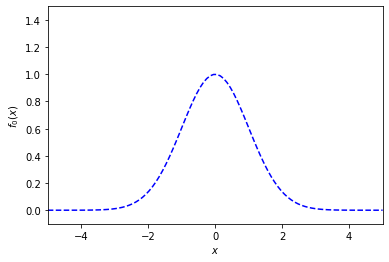

In [3]:
# let's see what the initial condition looks like

X_example = np.linspace(x_min, x_max, 10**2, endpoint = True)

f0_example = gaussian(X_example)

fig = plt.figure()
ax = fig.gca()

ax.set_xlim(x_min, x_max)
ax.set_ylim(-0.1, 1.5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f_{0}(x)$')

plt.plot(X_example, f0_example, 'b--')

plt.show()

<br/><br/>

## Tasks

### Core task 1

Our first algorithm will use the explicit upwind scheme. It is arguably the simplest algorithm within the class of finite difference schemes. 

The first idea is to discretize time and space. We will have instants ${ 0, \Delta t, 2 \Delta t, ..., T }$ and positions ${ -5, -5 + \Delta x, -5 + 2 \Delta x, ..., 5 - \Delta x }$. It is common practice to denote the time-frames with the subscript ${ ^{n} }$ and the cells with the superscript ${ _{i} }$. This leads to the notation

$$
f(n \Delta t, -5 + i \Delta x) = f(t^{n}, x_{i}) = f^{n}_{i} .
$$

In [4]:
# Let's define the parameters

# grid
n_points_space = 10**3
dx = (x_max - x_min) / n_points_space
dt = 0.05

The second idea is to replace the time derivative on the left hand side by
$$
\frac{f^{n+1}_{i} - f^{n}_{i}}{\Delta t} ,
$$
and the space derivative on the right-hand side by
$$
\frac{f^{n}_{i} - f^{n}_{i - 1}}{\Delta x} .
$$
From the definition of the partial derivative, it is intuitive that if ${ \Delta t }$ and ${ \Delta x }$ are both small, this replacement should not cause a big error.

This trick leaves us with the equation
$$
f^{n+1}_{i} = f^{n}_{i} + dt \times -v \frac{f^{n}_{i} - f^{n}_{i - 1}}{\Delta x}
$$
which gives ${ f^{n+1} }$ from ${ f^{n} }$. This will allow us to easily the initial condition time-frame by time-frame all the way to ${ t_{\text{max}} }$.

**Implement the explicit upwind scheme by completing the following piece of code.**

In [5]:
def Upwind_explicit(v, n_points_space, dx, dt):
    df_dt = np.zeros(n_points_space, dtype = np.float64)

    def step(f):
      for i in range(n_points_space):
        if i == 0: # for boundary value
          f[i] += dt * (-v) * (f[i]-f[-1]) / dx
        else:
          f[i] += dt * (-v) * (f[i]-f[i-1]) / dx
    return step

**To sanity-check on your code, run the following piece of code and convince yourself that your scheme solves the advection equation correctly**

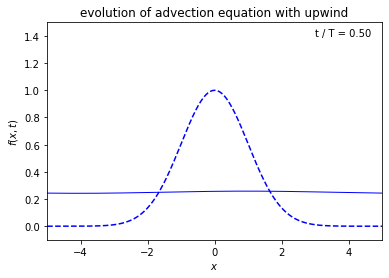

In [6]:
# initial condition
X = np.linspace(x_min, x_max, n_points_space, endpoint = True)
f0 = gaussian(X)
f = f0.copy()

# scheme
step = Upwind_explicit(v, n_points_space, dx, dt)

# preparation of the animation
fig = plt.figure()
ax = fig.gca()

ax.set_xlim(x_min, x_max)
ax.set_ylim(-0.1, 1.5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x, t)$')
ax.set_title("evolution of advection equation with upwind")
show_f0, = ax.plot(X, f0, 'b--', label = "f0")
show_ft, = ax.plot([], [], 'b', lw = 1, ms = 2, label = "f")
time = ax.annotate(0, xy = (3, 1.4), xytext = (3, 1.4))

# integration
num_frames = 100
def animate(i):
    for _ in range(num_frames):
      step(f)
    # step(f)
    show_ft.set_data(X, f)
  
    time.set_text("t / T = %.2f" % (v * i * dt / (x_max - x_min)))

    return show_f0, show_ft
anim = animation.FuncAnimation(fig, animate, 10**5//num_frames, interval = dt * 800, blit = True)
HTML(anim.to_html5_video())

**Explore the errors made by your code. What happens if you wait for a few periods?**

There is a reduction in amplitude as we can see in the final snapshot the curve is almost completely flat

We can write out the equation as
$$
f^{n+1}_{i} = f^{n}_{i} - C(f^{n}_{i} - f^{n}_{i - 1})
$$

with $C$ as the Courant number
$$
C = \frac{v\Delta t}{\Delta x}\thinspace .
$$

In [7]:
print("Courant number:", v*dt/dx)

Courant number: 0.5000000000000001


Generally a stable scheme has $C\leq 1$. This is known as Courant–Friedrichs–Lewy condition (CFL) condition.
It becomes exact if $C=1$. This is easy to see since
$C=1$ gives the property .
However, any $C<1$ gives a significant reduction in the amplitude of the
solution after a few periods, which is a purely numerical effect. Near the center of the peak, the gradient is significantly underestimated resulting in the spread.
Experiments below show, however, that
reducing $\Delta t$ or $\Delta x$, while keeping $C$ reduces the
error.

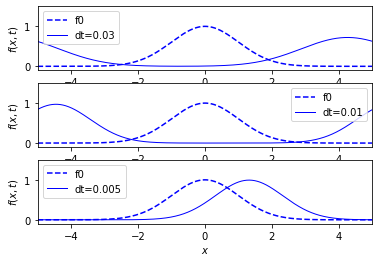

In [8]:
# initial condition
dt = [0.03, 0.01, 0.005]
X = np.linspace(x_min, x_max, n_points_space, endpoint = True)
f0 = gaussian(X)
f1 = f0.copy()
f2 = f0.copy()
f3 = f0.copy()
# scheme
step0 = Upwind_explicit(v, n_points_space, dx, dt[0])
step1 = Upwind_explicit(v, n_points_space, dx, dt[1])
step2 = Upwind_explicit(v, n_points_space, dx, dt[2])

  # preparation of the animation
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
for ax in [ax1, ax2, ax3]:
  ax.set_xlim(x_min, x_max)
  ax.set_ylim(-0.1, 1.5)

  ax.set_xlabel(r'$x$')
  ax.set_ylabel(r'$f(x, t)$')

  show_f0, = ax.plot(X, f0, 'b--', label = "f0")


for i in range(15000):
  step0(f1)
for i in range(5000):
  step1(f2)
for i in range(2500):
  step2(f3)

show_ft1, = ax1.plot(X, f1, 'b', lw = 1, ms = 2, label = "dt=0.03")
ax1.legend()
show_ft2, = ax2.plot(X, f2, 'b', lw = 1, ms = 2, label = "dt=0.01")
ax2.legend()
show_ft3, = ax3.plot(X, f3, 'b', lw = 1, ms = 2, label = "dt=0.005")
ax3.legend()
plt.show()

We have above 3 different snapshots of the advection evolution after the same duration and we can see that with smaller dt, the less the amplitude is affected by the reduction.

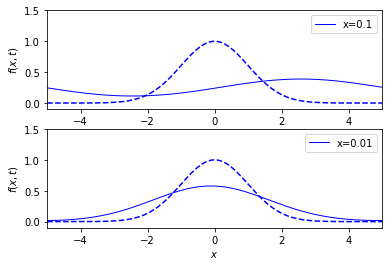

In [9]:
# initial condition
n_points_space = [100, 1000]
labels = ["x=0.1","x=0.01"]
dt = 0.05
X1 = np.linspace(x_min, x_max, n_points_space[0], endpoint = True)
X2 = np.linspace(x_min, x_max, n_points_space[1], endpoint = True)

X = [X1, X2]
F = [gaussian(X1), gaussian(X2)]


# scheme
step0 = Upwind_explicit(v, n_points_space[0], (x_max - x_min) / n_points_space[0], dt)
step1 = Upwind_explicit(v, n_points_space[1], (x_max - x_min) / n_points_space[1], dt)

  # preparation of the animation
fig, axes = plt.subplots(nrows=2, ncols=1)
for i in range(2):
  axes[i].set_xlim(x_min, x_max)
  axes[i].set_ylim(-0.1, 1.5)

  axes[i].set_xlabel(r'$x$')
  axes[i].set_ylabel(r'$f(x, t)$')

  show_f0, = axes[i].plot(X[i], F[i], 'b--')
  

num_step = 10000
for i in range(num_step):
  step0(F[0])
  step1(F[1])

show_ft1, = axes[0].plot(X[0], F[0], 'b', lw = 1, ms = 2, label=labels[0])
axes[0].legend()
show_ft2, = axes[1].plot(X[1], F[1], 'b', lw = 1, ms = 2, label=labels[1])
axes[1].legend()
plt.show()

The similar experiment demonstrated above for changing dx.

**Run the same code, but with a larger ${ \Delta t }$ of 1.1. What happens?**

<ipython-input-5-f8a28d899f85>:9: RuntimeWarning: overflow encountered in double_scalars
  f[i] += dt * (-v) * (f[i]-f[i-1]) / dx
<ipython-input-5-f8a28d899f85>:9: RuntimeWarning: invalid value encountered in double_scalars
  f[i] += dt * (-v) * (f[i]-f[i-1]) / dx


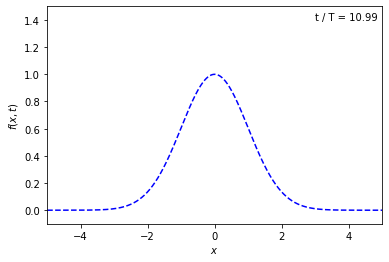

In [10]:
dt = 1.1
# initial condition
n_points_space = 1000
X = np.linspace(x_min, x_max, n_points_space, endpoint = True)
f0 = gaussian(X)
f = f0.copy()

# scheme
step = Upwind_explicit(v, n_points_space, dx, dt)

# preparation of the animation
fig = plt.figure()
ax = fig.gca()

ax.set_xlim(x_min, x_max)
ax.set_ylim(-0.1, 1.5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x, t)$')

show_f0, = ax.plot(X, f0, 'b--', label = "f0")
show_ft, = ax.plot([], [], 'b', lw = 1, ms = 2, label = "f")
time = ax.annotate(0, xy = (3, 1.4), xytext = (3, 1.4))

num_frames = 100
def animate(i):
    for _ in range(num_frames):
      step(f)
    # step(f)
    show_ft.set_data(X, f)
  
    time.set_text("t / T = %.2f" % (v * i * dt / (x_max - x_min)))

    return show_f0, show_ft
anim = animation.FuncAnimation(fig, animate, 10**5//num_frames, interval = dt * 800, blit = True)
HTML(anim.to_html5_video())

In [11]:
print(dt*v/dx)

11.000000000000002


Here our Courant number exceeds 1 so the system becomes unstable. We cannot even see the evolution. The whole curve just diverges

### Core task 2

Our second algorithm will use the Lax-Wendroff scheme, which is also a finite-difference method. It is slightly more complex, but as a reward it gives results that are closer to the truth. 

The first idea is that the way we replaced the derivatives by finite differences was quite arbitrary. This time, we will use a different formula. Let us replace the spatial derivative by
$$
\frac{f^{n}_{i+1} - f^{n}_{i-1}}{2 \Delta x} .
$$

The second idea is to work around the expected numerical diffusion by adding a fictitious "retro-diffusion" term. Without going into the mathematical details, it is possible to predict how much diffusion a finite difference will cause, and to add just the right amount of "retro-diffusion". The final equation is
$$
\frac{f^{n+1}_{i} - f^{n}_{i}}{\Delta t} = -v \frac{f^{n}_{i+1} - f^{n}_{i-1}}{2 \Delta x} + \frac{v^{2} \Delta t}{2} \frac{f^{n}_{i+1} - 2 f^{n}_{i} + f^{n}_{i-1}}{\Delta x^{2}} .
$$

**Implement the Lax-Wendroff scheme.**

In [12]:
n_points_space = 10**3
dx = (x_max - x_min) / n_points_space
dt = 0.05

In [13]:
def Lax_Wendroff(v, n_points_space, dx, dt):

    def step(f):
      f[:] += -v*dt*(np.roll(f,-1)-np.roll(f,1))/(2*dx)+v**2*dt**2*(np.roll(f,-1)-2*f+np.roll(f,1))/(2*dx**2)
    return step

 **Sanity-check your code.**

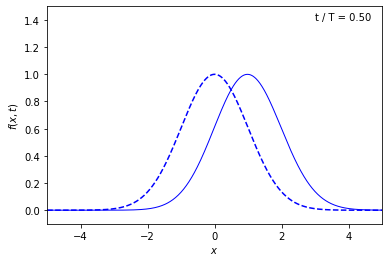

In [14]:
# initial condition
X = np.linspace(x_min, x_max, n_points_space, endpoint = True)
f0 = gaussian(X)
f = f0.copy()

# scheme
step = Lax_Wendroff(v, n_points_space, dx, dt)

# preparation of the animation
fig = plt.figure()
ax = fig.gca()

ax.set_xlim(x_min, x_max)
ax.set_ylim(-0.1, 1.5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x, t)$')

show_f0, = ax.plot(X, f0, 'b--', label = "f0")
show_ft, = ax.plot([], [], 'b', lw = 1, ms = 2, label = "f")
time = ax.annotate(0, xy = (3, 1.4), xytext = (3, 1.4))

num_frames = 100
def animate(i):
    for _ in range(num_frames):
      step(f)
    # step(f)
    show_ft.set_data(X, f)
  
    time.set_text("t / T = %.2f" % (v * i * dt / (x_max - x_min)))

    return show_f0, show_ft
anim = animation.FuncAnimation(fig, animate, 10**5//num_frames, interval = dt * 800, blit = True)
HTML(anim.to_html5_video())

**Run a few experiments to determine under which condition the Lax-Wendroff scheme is stable**

Write the Lax-Wendroff equation as 
$$
f^{n+1}_i = f^n_i - \frac{1}{2} C (f^{n}_{i+1} - f^{n}_{i-1})
+ \frac{1}{2} C^2 (f^{n}_{i+1}-2f^n_i+f^n_{i-1})\thinspace .
$$

and we take different C for experiment

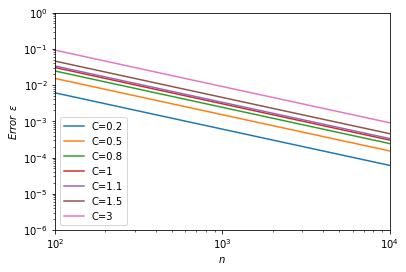

In [15]:
N = [(i + 1) * 10**2 for i in range(10)] + [(i + 1) * 10**3 for i in range(10)]
C = [0.2, 0.5, 0.8, 1, 1.1, 1.5, 3]

Errors = [[0.0 for i in range(20)], [0.0 for i in range(20)], [0.0 for i in range(20)], [0.0 for i in range(20)], [0.0 for i in range(20)], [0.0 for i in range(20)], [0.0 for i in range(20)]]

for j in range(len(C)):
  for i in range(20):
      n = N[i]

      # grid
      n_points_space = n
      dx = (x_max - x_min) / n_points_space
      n_points_time = 2 * n
      dt = C[j] * 100 / n_points_time

      # initial condition
      X = np.linspace(x_min, x_max, n_points_space, endpoint = True)
      f0 = gaussian(X)
      f = f0.copy()

      # scheme
      step = Lax_Wendroff(v, n_points_space, dx, dt)
      
      # integration
      # t = 0.0
      # for j in range(n_points_time):
      step(f)
      # t += dt
      
      # measure error
      error = np.max(np.abs(f - f0))
      
      Errors[j][i] = error

# plot the results
fig = plt.figure()
ax = fig.gca()

ax.set_xlim(N[0], N[-1])
ax.set_ylim(10**(-6), 10**0)

ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$Error \,\,\, \epsilon$')

ax.set_xscale('log')
ax.set_yscale('log')

labels = ["C=0.2","C=0.5","C=0.8","C=1","C=1.1","C=1.5","C=3"]
for i in range(len(C)):
  plt.plot(N, Errors[i], label=labels[i])
plt.legend()
plt.show()

We can see from error analysis above as C increase up to one the error accumulates towards around 0.7. But above one the error just grows fast and even to inf, e.g. C=3

**Is the Lax-Wendroff scheme diffusive? What happens if you wait for several period?**

It is a bit diffusive(dissipative) as well as dipersive

**Use the code below to measure the error made by the Lax-Wendroff scheme as a function of ${ \Delta t }$ and ${ \Delta x }$. How does the error scale?**

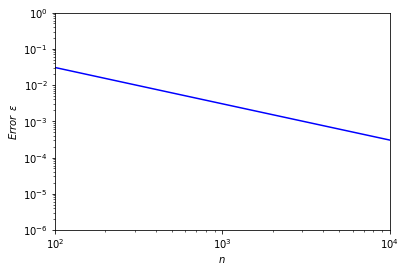

In [16]:
N = [(i + 1) * 10**2 for i in range(10)] + [(i + 1) * 10**3 for i in range(10)]
Errors = [0.0 for i in range(20)]

for i in range(20):
    n = N[i]

    # grid
    n_points_space = n
    dx = (x_max - x_min) / n_points_space
    n_points_time = 2 * n
    dt = 100 / n_points_time

    # initial condition
    X = np.linspace(x_min, x_max, n_points_space, endpoint = True)
    f0 = gaussian(X)
    f = f0.copy()

    # scheme
    step = Lax_Wendroff(v, n_points_space, dx, dt)
    
    # integration
    # t = 0.0
    # for j in range(n_points_time):
    step(f)
    # t += dt
    
    # measure error
    error = np.max(np.abs(f - f0))
    # print(error)
    Errors[i] = error

# plot the results
fig = plt.figure()
ax = fig.gca()

ax.set_xlim(N[0], N[-1])
ax.set_ylim(10**(-6), 10**0)

ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$Error \,\,\, \epsilon$')

ax.set_xscale('log')
ax.set_yscale('log')

plt.plot(N, Errors, 'b')

plt.show()

the error decreases as the number of points taken increases, which is to calculate the equation in a shorter time and space interval.

**Compare to the error made by the explicit upwind scheme. What scheme do you prefer, and why?**

Lax-Wendroff is more accurate because of the second order term. It means that we can take an unstable scheme and add some diffusion to stabilize it.

### Core task 3

So far, we have seen two finite difference methods. Our third algorithm will use a spectral method.

The central idea is to decompose the solution into Fourier modes of the form
$$
\hat{f} (k,t) = \int_{-\infty}^{+\infty} f (x,t) \,\, \mathrm{e}^{-i k x} dx. \qquad (1)
$$

By applying a Fourier transform to the advection equation, we obtain that the evolution of a Fourier mode is governed by
$$
\frac{\partial \hat{f}}{\partial t} = - i v k \hat{f} , \qquad (2)
$$
which is a simple ODE.

Finally, an inverse Fourier transform allows us to find the solution
$$
f (x,t) = \frac{1}{2 \pi} \int_{-\infty}^{+\infty} \hat{f} (k,t) \,\, \mathrm{e}^{+ i k x} dk . \qquad (3)
$$

Following this idea, we deduce a simple three-step algorithm that allows us to update the numerical solution from ${ f^{n} }$ to ${ f^{n+1} }$:

1. Calculate ${ \hat{f}^{n} }$ by applying a FFT procedure to ${ f^{n} }$.

2. Use equation (2) and your favorite order-1 scheme for ODEs to deduce ${ \hat{f}^{n+1} }$ from ${ \hat{f}^{n} }$.

3. Calculate ${ f^{n+1} }$ by applying a IFFT procedure to $\hat{f}^{n+1}$.

**Write your own spectral scheme**

In [17]:
n_points_space = 1000

In [18]:
def Spectral(v, n_points_space, dx, dt):

    def step(f):
      k=np.fft.fftfreq(n_points_space, dx)
      # k=np.fft.fftshift(k)
      F = np.fft.fft(f)
      # F = np.fft.fftshift(F)
      F[:] += dt * (1j) * v * np.multiply(np.roll(F,-1),np.roll(k,-1))
      f[:] = np.real(np.fft.ifft(F))
    
    return step

<ipython-input-18-517e9c00bcac>:8: RuntimeWarning: overflow encountered in multiply
  F[:] += dt * (1j) * v * np.multiply(np.roll(F,-1),np.roll(k,-1))
<ipython-input-18-517e9c00bcac>:8: RuntimeWarning: invalid value encountered in multiply
  F[:] += dt * (1j) * v * np.multiply(np.roll(F,-1),np.roll(k,-1))


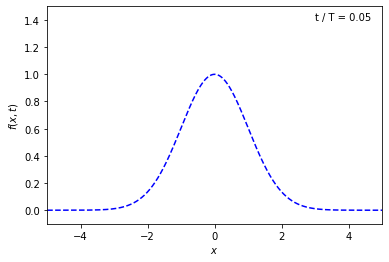

In [19]:
# initial condition
X = np.linspace(x_min, x_max, n_points_space, endpoint = True)
f0 = gaussian(X)
f = f0.copy()

# scheme
step = Spectral(v, n_points_space, dx, dt)

# preparation of the animation
fig = plt.figure()
ax = fig.gca()

ax.set_xlim(x_min, x_max)
ax.set_ylim(-0.1, 1.5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x, t)$')

show_f0, = ax.plot(X, f0, 'b--', label = "f0")
show_ft, = ax.plot([], [], 'b', lw = 1, ms = 2, label = "f")
time = ax.annotate(0, xy = (3, 1.4), xytext = (3, 1.4))


num_frames = 100
def animate(i):
    for _ in range(10):
      step(f)
    show_ft.set_data(X, f)
  
    time.set_text("t / T = %.2f" % (v * i * dt / (x_max - x_min)))

    return show_f0, show_ft
anim = animation.FuncAnimation(fig, animate, 10**5//num_frames, interval = dt * 800, blit = True)
HTML(anim.to_html5_video())

**Sanity-check your code. Under which conditions is it stable? How fast does it converge? What happens when you only use 10 cells in space?**

The function will eventually diverge. The fourier transform of f has a relation of $\tilde{f^n} = \tilde{f^{n-1}} (1-ivkdt)$. Applying Euler criterion, $|1-ivkdt|$ is always larger than 1. However, with a smaller courant number, we can control the diverge rate with more periods. Also, in the ODE calculation, we should choose backward(implicit) Euler method instead of forward(explicit) method. This way the divergence will be reduced.

Now we switch to 10 cells in space for experiment.

<ipython-input-18-517e9c00bcac>:8: RuntimeWarning: overflow encountered in multiply
  F[:] += dt * (1j) * v * np.multiply(np.roll(F,-1),np.roll(k,-1))
<ipython-input-18-517e9c00bcac>:8: RuntimeWarning: invalid value encountered in multiply
  F[:] += dt * (1j) * v * np.multiply(np.roll(F,-1),np.roll(k,-1))


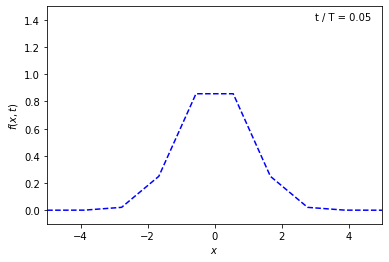

In [20]:
n_points_space = 10
# initial condition
X = np.linspace(x_min, x_max, n_points_space, endpoint = True)
f0 = gaussian(X)
f = f0.copy()

# scheme
step = Spectral(v, n_points_space, dx, dt)

# preparation of the animation
fig = plt.figure()
ax = fig.gca()

ax.set_xlim(x_min, x_max)
ax.set_ylim(-0.1, 1.5)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x, t)$')

show_f0, = ax.plot(X, f0, 'b--', label = "f0")
show_ft, = ax.plot([], [], 'b', lw = 1, ms = 2, label = "f")
time = ax.annotate(0, xy = (3, 1.4), xytext = (3, 1.4))


num_frames = 100
def animate(i):
    for _ in range(10):
      step(f)
    show_ft.set_data(X, f)
  
    time.set_text("t / T = %.2f" % (v * i * dt / (x_max - x_min)))

    return show_f0, show_ft
anim = animation.FuncAnimation(fig, animate, 10**5//num_frames, interval = dt * 800, blit = True)
HTML(anim.to_html5_video())

We can see that the space is clipped because of the coarse estimation on the space distribution. And the divergence still exists. But in the fourier domain, as the gaps between dx increases, the gap for k decreases. So it looks better than 1000 cells space. However, again, this means that the dx is much larger than before and the finite method will not be able to simulate the evolution properly.